In [88]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import scipy
from scipy import stats

In [49]:
root='.'
root2='/Genomics/pritykinlab/zzhao/metabolic_analysis'
filename = f'{root}/data/th_data/GSE162300_DFMO_RNA_TPMs.tsv'
reaction_meta_file = f'{root2}/Compass/compass/Resources/Recon2_export/rxn_md.csv'
reaction_output_file = f'{root}/compass_results/reactions.tsv'
out_dir = f'{root}/compass_comparison/'
hypergeom_dir = f'{root}/compass_hypergeom_results/'

In [3]:
reaction_metadata = pd.read_csv(reaction_meta_file, index_col = 0)
reaction_penalties = pd.read_csv(reaction_output_file, sep='\t', index_col=0)
reaction_metadata

,rxn_name_long,subsystem,ind_in_original_recon,rxn_EC_number,genes_associated_with_rxn,rxn_formula,rxn_confidence
rxn_code_nodirection,,,,,,,
10FTHF5GLUtl,"5-glutamyl-10FTHF transport, lysosomal","Transport, lysosomal",1,NaN,NaN,1.00 * 10-formyltetrahydrofolate-[Glu](5) [c] ...,2.0
10FTHF5GLUtm,"5-glutamyl-10FTHF transport, mitochondrial","Transport, mitochondrial",2,NaN,NaN,1.00 * 10-formyltetrahydrofolate-[Glu](5) [m] ...,2.0
10FTHF6GLUtl,"6-glutamyl-10FTHF transport, lysosomal","Transport, lysosomal",3,NaN,NaN,1.00 * 10-formyltetrahydrofolate-[Glu](6) [c] ...,2.0
10FTHF6GLUtm,"6-glutamyl-10FTHF transport, mitochondrial","Transport, mitochondrial",4,NaN,NaN,1.00 * 10-formyltetrahydrofolate-[Glu](6) [m] ...,2.0
10FTHF7GLUtl,"7-glutamyl-10FTHF transport, lysosomal","Transport, lysosomal",5,NaN,NaN,1.00 * 10-formyltetrahydrofolate-[Glu](7) [c] ...,2.0
...,...,...,...,...,...,...,...
MAL_Lte,Transport of L-malate,"Transport, extracellular",7436,NaN,NaN,1.00 * (S)-malate(2-) [e] --> 1.00 * (S)-malat...,NaN
OROTGLUt,OROTGLUt,"Transport, extracellular",7437,NaN,SLC22A7,1.00 * L-glutamate(1-) [c] + 1.00 * Orotate [e...,NaN
PNTOte,Transport of (R)-Pantothenate,"Transport, extracellular",7438,NaN,NaN,1.00 * (R)-Pantothenate [e] --> 1.00 * (R)-Pan...,NaN


In [4]:
#This function is repeated here for clarity
def get_reaction_consistencies(compass_reaction_penalties, min_range=1e-3):
    """
        Converts the raw penalties outputs of compass into scores per reactions where higher numbers indicate more activity
    """
    df = -np.log(compass_reaction_penalties + 1)
    df = df[df.max(axis=1) - df.min(axis=1) >= min_range]
    df = df - df.min().min()
    return df

In [5]:
reaction_consistencies = get_reaction_consistencies(reaction_penalties)

In [6]:
from compass_analysis import cohens_d, wilcoxon_test, get_reaction_consistencies, get_metareactions, labeled_reactions, amino_acid_metab


In [7]:
Th17p_Vehicle = reaction_consistencies.filter(like='Th17p_Vehicle').columns
print(Th17p_Vehicle)
Th17n_Vehicle = reaction_consistencies.filter(like='Th17n_Vehicle').columns
print(Th17n_Vehicle)

Index(['Th17p_Vehicle_WT1_run1', 'Th17p_Vehicle_WT1_run2',
       'Th17p_Vehicle_WT2_run1', 'Th17p_Vehicle_WT2_run2',
       'Th17p_Vehicle_WT3_run1', 'Th17p_Vehicle_WT3_run2'],
      dtype='object')
Index(['Th17n_Vehicle_WT1_run1', 'Th17n_Vehicle_WT1_run2',
       'Th17n_Vehicle_WT2_run1', 'Th17n_Vehicle_WT2_run2',
       'Th17n_Vehicle_WT3_run1', 'Th17n_Vehicle_WT3_run2'],
      dtype='object')


In [8]:
wilcox_results = wilcoxon_test(reaction_consistencies, Th17p_Vehicle, Th17n_Vehicle)
# wilcox_results = wilcoxon_test(reaction_consistencies, Th17p, Th17n)
wilcox_results['metadata_r_id'] = ""
for r in wilcox_results.index:
    if r in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur")

In [9]:
wilcox_results

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval,metadata_r_id
10FTHF5GLUtl_pos,33.0,0.015152,2.159993,0.035875,10FTHF5GLUtl
10FTHF5GLUtm_pos,34.0,0.008658,1.787591,0.027357,10FTHF5GLUtm
10FTHF6GLUtl_pos,33.0,0.015152,1.988012,0.035875,10FTHF6GLUtl
10FTHF6GLUtm_pos,34.0,0.008658,1.821178,0.027357,10FTHF6GLUtm
10FTHF7GLUtl_pos,33.0,0.015152,1.723774,0.035875,10FTHF7GLUtl
...,...,...,...,...,...
sink_decdicoa(c)_neg,28.0,0.132035,1.275588,0.178821,sink_decdicoa(c)
sink_octdececoa(c)_neg,34.0,0.008658,2.464836,0.027357,sink_octdececoa(c)
sink_pre_prot(r)_neg,28.0,0.132035,1.279011,0.178821,sink_pre_prot(r)
sink_tetdec2coa(c)_neg,28.0,0.132035,1.275588,0.178821,sink_tetdec2coa(c)


In [37]:
W = wilcox_results.merge(reaction_metadata, how='left',
                         left_on='metadata_r_id', right_index=True, validate='m:1')
# W = W[W['rxn_confidence'].isin([0,4])]
W = W[W['rxn_confidence'].isin([1,2,3,4])]
W = W[~W['rxn_EC_number'].isna()]
# new
W = W[~W['genes_associated_with_rxn'].isna()]
W.loc[(W['rxn_formula'].map(lambda x: '[m]' not in x)) & (W['subsystem'] == "Citric acid cycle"), 'subsystem'] = 'Other'

In [38]:
W[W['adjusted_pval']<0.05].sort_values(by=['adjusted_pval'])

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval,metadata_r_id,rxn_name_long,subsystem,ind_in_original_recon,rxn_EC_number,genes_associated_with_rxn,rxn_formula,rxn_confidence
34DHOXPEGOX_pos,36.0,0.002165,3.258966,0.014495,34DHOXPEGOX,"3,4-Dihydroxyphenylethyleneglycol:NAD+ oxidore...",Tyrosine metabolism,47,1.1.1.1,ADH1; ADH4; ADH5; ADH6A; ADH7; ADHFE1,1.00 * proton [c] + 1.00 * Nicotinamide adenin...,4.0
NACHEX6ly_pos,36.0,0.002165,2.355669,0.014495,NACHEX6ly,"beta-N-acetylhexosaminidase, lysosomal",Chondroitin sulfate degradation,2639,3.2.1.52,HEXA; HEXB,1.00 * Water [l] + 1.00 * chondroitin sulfate ...,4.0
MTHFR3_pos,36.0,0.002165,2.669348,0.014495,MTHFR3,"5,10-methylenetetrahydrofolatereductase (NADPH)",Folate metabolism,7373,1.5.1.20,MTHFR,2.00 * proton [c] + 1.00 * Nicotinamide adenin...,2.0
MTHFD_pos,36.0,0.002165,2.324762,0.014495,MTHFD,methylenetetrahydrofolate dehydrogenase (NADP),Folate metabolism,2602,1.5.1.5,MTHFD1; MTHFR,1.00 * Nicotinamide adenine dinucleotide phosp...,4.0
MTHFD2_neg,36.0,0.002165,2.324762,0.014495,MTHFD2,methylenetetrahydrofolate dehydrogenase (NAD),Folate metabolism,2603,1.5.1.5,MTHFD2; MTHFD2L,1.00 * Nicotinamide adenine dinucleotide [c] +...,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
NACHEX17ly_pos,33.0,0.015152,1.787042,0.035875,NACHEX17ly,"beta-N-acetylhexosaminidase, lysosomal",Keratan sulfate degradation,2623,3.2.1.52,HEXA; HEXB,"1.00 * Water [l] + 1.00 * keratan sulfate I, d...",4.0
NACHEX18ly_pos,33.0,0.015152,1.787042,0.035875,NACHEX18ly,"beta-N-acetylhexosaminidase, lysosomal",Keratan sulfate degradation,2624,3.2.1.52,HEXA; HEXB,"1.00 * Water [l] + 1.00 * keratan sulfate I, d...",4.0
NACHEX19ly_pos,33.0,0.015152,1.787042,0.035875,NACHEX19ly,"beta-N-acetylhexosaminidase, lysosomal",Keratan sulfate degradation,2625,3.2.1.52,HEXA; HEXB,"1.00 * Water [l] + 1.00 * keratan sulfate I, d...",4.0
IDOAASE2ly_pos,33.0,0.015152,1.700382,0.035875,IDOAASE2ly,"alpha-L-iduronidase, lysosomal",Heparan sulfate degradation,2319,3.2.1.76,IDUA,"1.00 * Water [l] + 1.00 * heparan sulfate, deg...",4.0


In [39]:
W[W['adjusted_pval']<0.05]['subsystem'].value_counts()

Nucleotide interconversion     128
Fatty acid oxidation            51
Keratan sulfate degradation     42
Sphingolipid metabolism         41
Keratan sulfate synthesis       33
                              ... 
Biotin metabolism                1
Transport, lysosomal             1
Cytochrome metabolism            1
Propanoate metabolism            1
Citric acid cycle                1
Name: subsystem, Length: 63, dtype: int64

In [40]:
gene_set_all = []
for gene_list in W[W['adjusted_pval']<0.05]['genes_associated_with_rxn'].values:
    if type(gene_list) is not float:
        gene_set_all.extend(gene_list.split('; '))
print(len(gene_set_all))

1312


In [41]:
from collections import Counter
Counter(gene_set_all).most_common()

[('CMPK1', 74),
 ('HEXA', 22),
 ('HEXB', 22),
 ('CTSA', 22),
 ('GALNS', 22),
 ('GLB1', 22),
 ('NEU1', 22),
 ('GM20390', 21),
 ('NME2', 21),
 ('FPGS', 18),
 ('B4GALT1', 16),
 ('B4GALT2', 16),
 ('B4GALT3', 16),
 ('B4GALT5', 16),
 ('B3GNT2', 15),
 ('B3GNT3', 15),
 ('B3GNT4', 15),
 ('B3GNT7', 15),
 ('B3GNT8', 15),
 ('B3GNTL1', 15),
 ('B4GAT1', 15),
 ('CPT1A', 14),
 ('GNS', 14),
 ('CPT1B', 13),
 ('CPT1C', 13),
 ('ACADM', 12),
 ('ACADS', 12),
 ('PNP2', 12),
 ('FUT9', 11),
 ('EHHADH', 9),
 ('NT5C', 9),
 ('NT5C3', 9),
 ('NT5E', 9),
 ('ACOX1', 8),
 ('ACSL1', 8),
 ('ST6GALNAC2', 8),
 ('ACAA1B', 7),
 ('HSD17B4', 7),
 ('FUT1', 7),
 ('GUSB', 7),
 ('NT5C1A', 7),
 ('NT5C1B', 7),
 ('SULT1A1', 6),
 ('HADHB', 6),
 ('NT5C2', 6),
 ('ST8SIA5', 6),
 ('UGT1A8', 6),
 ('ELOVL2', 5),
 ('ELOVL5', 5),
 ('ELOVL6', 5),
 ('MTHFD1', 5),
 ('NAGLU', 5),
 ('BCAT2', 5),
 ('CYP27A1', 5),
 ('ADH1', 4),
 ('ADH4', 4),
 ('ADH5', 4),
 ('ADH6A', 4),
 ('ADH7', 4),
 ('ADHFE1', 4),
 ('ADA', 4),
 ('ENTPD1', 4),
 ('ENTPD3', 4),
 ('E

In [42]:
W['subsystem'].value_counts()

Nucleotide interconversion     174
Fatty acid oxidation           145
Keratan sulfate degradation     59
Sphingolipid metabolism         44
Tyrosine metabolism             41
                              ... 
Ubiquinone synthesis             1
Vitamin C metabolism             1
CoA synthesis                    1
O-glycan synthesis               1
Thiamine metabolism              1
Name: subsystem, Length: 75, dtype: int64

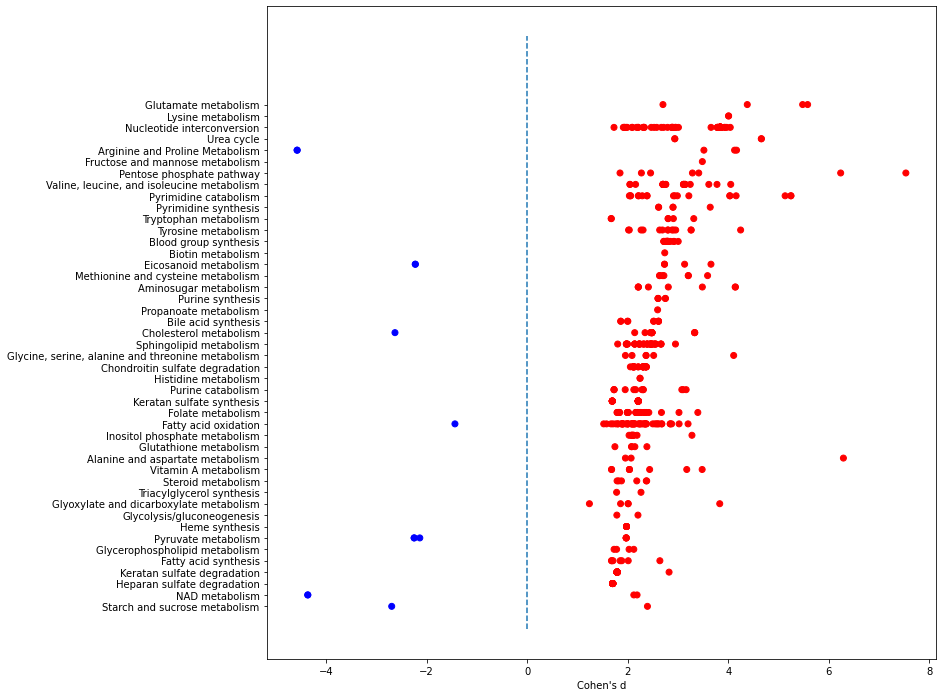

In [67]:
# only significant
data = W[~W['subsystem'].isin(["Miscellaneous", "Unassigned"])]
data = data[~data['subsystem'].map(lambda x: "Transport" in x or "Exchange" in x or x == "Other")]
items, counts = np.unique(data['subsystem'], return_counts=True)
items = [items[i] for i in range(len(items)) if counts[i] > 5] #filter(n() > 5) %>%
data = data[data['subsystem'].isin(items)]
data = data[data['adjusted_pval'] < 0.05]
plt.figure(figsize=(12,12))
axs = plt.gca()
#Sorts the reactions for plotting
d = data[data['adjusted_pval'] < 0.05].groupby('subsystem')['cohens_d'].median().abs()
axs.scatter(d[d.argsort], d[d.argsort].index, alpha=0)
color = data['cohens_d'].map(lambda x: 'r' if x >= 0 else 'b')
alpha = data['adjusted_pval'].map(lambda x: 1.0 if x < 0.1 else 0.25)
axs.scatter(data['cohens_d'], data['subsystem'], c=color, alpha=alpha)
axs.set_xlabel("Cohen's d")
axs.vlines(x=0, ymin=-2, ymax=50, linestyles='--')

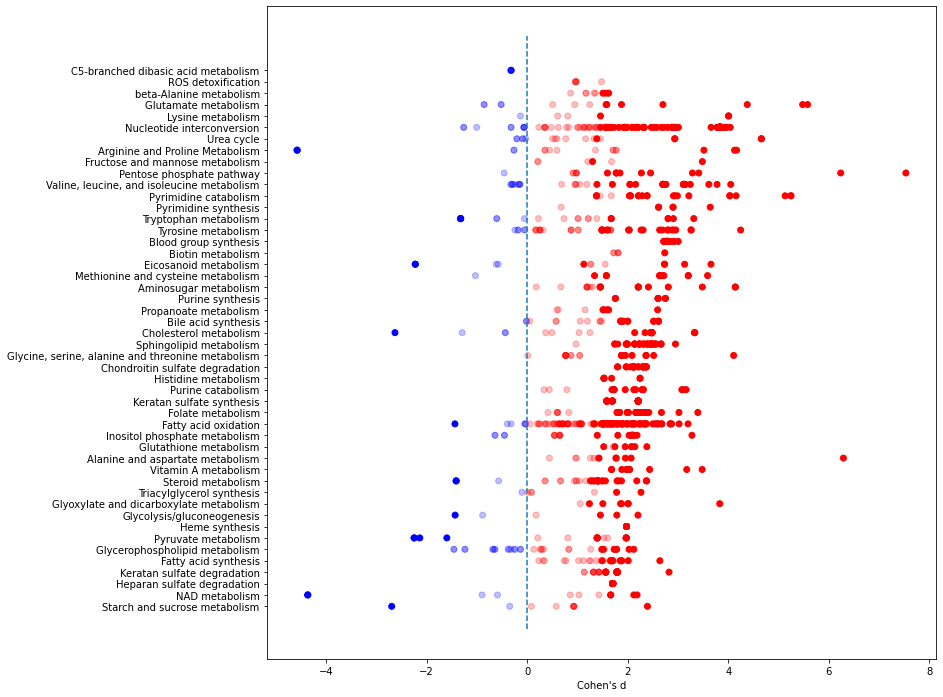

In [43]:
# all p values plotted
data = W[~W['subsystem'].isin(["Miscellaneous", "Unassigned"])]
data = data[~data['subsystem'].map(lambda x: "Transport" in x or "Exchange" in x or x == "Other")]
items, counts = np.unique(data['subsystem'], return_counts=True)
items = [items[i] for i in range(len(items)) if counts[i] > 5] #filter(n() > 5) %>%
data = data[data['subsystem'].isin(items)]
plt.figure(figsize=(12,12))
axs = plt.gca()
#Sorts the reactions for plotting
d = data[data['adjusted_pval'] < 0.05].groupby('subsystem')['cohens_d'].median().abs()
axs.scatter(d[d.argsort], d[d.argsort].index, alpha=0)
color = data['cohens_d'].map(lambda x: 'r' if x >= 0 else 'b')
alpha = data['adjusted_pval'].map(lambda x: 1.0 if x < 0.1 else 0.25)
axs.scatter(data['cohens_d'], data['subsystem'], c=color, alpha=alpha)
axs.set_xlabel("Cohen's d")
axs.vlines(x=0, ymin=-2, ymax=50, linestyles='--')

In [44]:
print(data[data['adjusted_pval'] < 0.05].groupby('subsystem')['cohens_d'].quantile([.25]))

subsystem                                              
Alanine and aspartate metabolism                   0.25    2.008974
Aminosugar metabolism                              0.25    2.208438
Arginine and Proline Metabolism                    0.25   -4.576983
Bile acid synthesis                                0.25    1.992928
Biotin metabolism                                  0.25    2.734501
Blood group synthesis                              0.25    2.759555
Cholesterol metabolism                             0.25    2.455463
Chondroitin sulfate degradation                    0.25    2.125289
Eicosanoid metabolism                              0.25   -0.987563
Fatty acid oxidation                               0.25    1.899411
Fatty acid synthesis                               0.25    1.692693
Folate metabolism                                  0.25    1.832860
Fructose and mannose metabolism                    0.25    3.482494
Glutamate metabolism                               0.25    3

# compare results to hypergeom test

In [47]:
#data.to_csv(out_dir + 'compass_results_data.csv')

In [48]:
# data = pd.read_csv(out_dir + 'compass_results_data.csv', index_col = 0)
data

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval,metadata_r_id,rxn_name_long,subsystem,ind_in_original_recon,rxn_EC_number,genes_associated_with_rxn,rxn_formula,rxn_confidence
13DAMPPOX_pos,29.0,0.093074,1.166851,0.143388,13DAMPPOX,"1,3-Diaminopropane:oxygen oxidoreductase (deam...",beta-Alanine metabolism,13,1.4.3.6,AOC1; AOC2; AOC3,1.00 * trimethylenediaminium [c] + 1.00 * Wate...,1.0
2HBO_neg,27.0,0.179654,1.151280,0.231466,2HBO,2-Hydroxybutyrate:NAD+ oxidoreductase,Propanoate metabolism,41,1.1.1.27,LDHA; LDHAL6B; LDHB; LDHC; UEVLD,1.00 * 2-Hydroxybutyrate [c] + 1.00 * Nicotina...,4.0
2HBO_pos,31.0,0.041126,1.585189,0.074814,2HBO,2-Hydroxybutyrate:NAD+ oxidoreductase,Propanoate metabolism,41,1.1.1.27,LDHA; LDHAL6B; LDHB; LDHC; UEVLD,1.00 * 2-Hydroxybutyrate [c] + 1.00 * Nicotina...,4.0
2OXOADOXm_pos,23.0,0.484848,0.805125,0.542620,2OXOADOXm,2-Oxoadipate:lipoamde 2-oxidoreductase(decarbo...,Lysine metabolism,45,2.3.1.61,DLD; DLST; OGDH; PDHX,1.00 * 2-oxoadipate(2-) [m] + 1.00 * Coenzyme ...,2.0
34DHOXPEGOX_pos,36.0,0.002165,3.258966,0.014495,34DHOXPEGOX,"3,4-Dihydroxyphenylethyleneglycol:NAD+ oxidore...",Tyrosine metabolism,47,1.1.1.1,ADH1; ADH4; ADH5; ADH6A; ADH7; ADHFE1,1.00 * proton [c] + 1.00 * Nicotinamide adenin...,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
XAO2x_pos,20.0,0.818182,0.335568,0.848828,XAO2x,xanthine oxidase,Purine catabolism,3711,1.1.1.204,XDH,1.00 * O2 [x] + 1.00 * Water [x] + 1.00 * Hypo...,4.0
XAOx_pos,21.0,0.699134,0.437026,0.751059,XAOx,"xanthine oxidase,peroxisomal",Purine catabolism,3712,1.1.1.204,XDH,1.00 * O2 [x] + 1.00 * Water [x] + 1.00 * Xant...,4.0
XYLK_pos,32.0,0.025974,1.594498,0.051139,XYLK,xylulokinase,Pentose phosphate pathway,3730,2.7.1.17,XYLB,1.00 * ATP [c] + 1.00 * D-xylulose [c] --> 1.0...,4.0
XYLUR_neg,36.0,0.002165,7.530267,0.014495,XYLUR,xylulose reductase,Pentose phosphate pathway,3736,1.1.1.10,DCXR,1.00 * proton [c] + 1.00 * Nicotinamide adenin...,4.0


In [52]:
sig_data = data[data['adjusted_pval'] < 0.05]
sig_data

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval,metadata_r_id,rxn_name_long,subsystem,ind_in_original_recon,rxn_EC_number,genes_associated_with_rxn,rxn_formula,rxn_confidence
34DHOXPEGOX_pos,36.0,0.002165,3.258966,0.014495,34DHOXPEGOX,"3,4-Dihydroxyphenylethyleneglycol:NAD+ oxidore...",Tyrosine metabolism,47,1.1.1.1,ADH1; ADH4; ADH5; ADH6A; ADH7; ADHFE1,1.00 * proton [c] + 1.00 * Nicotinamide adenin...,4.0
3DSPHR_pos,34.0,0.008658,2.137265,0.027357,3DSPHR,3-Dehydrosphinganine reductase,Sphingolipid metabolism,63,1.1.1.102,KDSR,1.00 * proton [c] + 1.00 * Nicotinamide adenin...,4.0
3SALATAi_pos,36.0,0.002165,2.688764,0.014495,3SALATAi,3-sulfino-alanine transaminase (irreversible),Methionine and cysteine metabolism,84,2.6.1.1,GOT1,1.00 * proton [c] + 1.00 * 2-Oxoglutarate [c] ...,2.0
3SALATAim_pos,36.0,0.002165,2.717783,0.014495,3SALATAim,"3-sulfino-alanine transaminase (irreversible),...",Methionine and cysteine metabolism,85,2.6.1.1,GOT2,1.00 * proton [m] + 1.00 * 2-Oxoglutarate [m] ...,2.0
41R1H2MAE12BOOX_pos,36.0,0.002165,2.797785,0.014495,41R1H2MAE12BOOX,"4-[(1R)-1-Hydroxy-2-(methylamino)ethyl]-1,2-be...",Tyrosine metabolism,88,1.4.3.4,MAOA; MAOB,1.00 * Water [c] + 1.00 * O2 [c] + 1.00 * Adre...,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
VALTA_pos,36.0,0.002165,2.699036,0.014495,VALTA,valine transaminase,"Valine, leucine, and isoleucine metabolism",3689,2.6.1.42,BCAT1,1.00 * 2-Oxoglutarate [c] + 1.00 * L-valine [c...,4.0
VALTAm_neg,36.0,0.002165,2.699036,0.014495,VALTAm,"valine transaminase, mitochondiral","Valine, leucine, and isoleucine metabolism",3690,2.6.1.42,BCAT2,1.00 * 2-Oxoglutarate [m] + 1.00 * L-valine [m...,4.0
VLCSp_pos,36.0,0.002165,2.610697,0.014495,VLCSp,Very-long-chain-fatty-acid-CoA ligase,Bile acid synthesis,3703,6.2.1.7,SLC27A2,1.00 * Coenzyme A [x] + 1.00 * ATP [x] + 1.00 ...,4.0
XYLUR_neg,36.0,0.002165,7.530267,0.014495,XYLUR,xylulose reductase,Pentose phosphate pathway,3736,1.1.1.10,DCXR,1.00 * proton [c] + 1.00 * Nicotinamide adenin...,4.0


## subsystem level

In [141]:
pvn_sub_all = pd.read_csv(hypergeom_dir + 'results_Th17p_v_n_compass_rxns_q.csv', index_col = 0)
nvp_sub_all = pd.read_csv(hypergeom_dir + 'results_Th17n_v_p_compass_rxns_q.csv', index_col = 0)
pvn_sub = pvn_sub_all[pvn_sub_all['q'] < 0.05]
nvp_sub = nvp_sub_all[nvp_sub_all['q'] < 0.05]
subsystem_terms = pd.read_csv(hypergeom_dir + 'subsystem_term_names.csv')['0']

In [63]:
sig_data[sig_data['cohens_d'] > 0]['subsystem'].value_counts()

Nucleotide interconversion                           128
Fatty acid oxidation                                  50
Keratan sulfate degradation                           42
Sphingolipid metabolism                               41
Keratan sulfate synthesis                             33
Folate metabolism                                     31
Chondroitin sulfate degradation                       22
Valine, leucine, and isoleucine metabolism            22
Blood group synthesis                                 20
Pyrimidine catabolism                                 18
Heparan sulfate degradation                           18
Cholesterol metabolism                                15
Tyrosine metabolism                                   14
Purine catabolism                                     12
Bile acid synthesis                                    9
Inositol phosphate metabolism                          9
Vitamin A metabolism                                   8
Aminosugar metabolism          

In [57]:
pvn_sub

,term,p,padj,q
1,Nucleotide interconversion,0.002879,NaN,0.031141
12,"Valine, leucine, and isoleucine metabolism",0.002096,NaN,0.031141
17,"Glycine, serine, alanine and threonine metabolism",0.003426,NaN,0.031141
27,Pentose phosphate pathway,0.008620,NaN,0.047020
45,Purine synthesis,0.005890,NaN,0.040161
59,"Transport, lysosomal",0.010499,NaN,0.047724


In [243]:
# 1: get proportion of shared items that are significant
def get_overlap(compass, hypergeom, col1 = 'term', col2 = 'subsystem'):
    intersection = len(set(hypergeom[col1]) & set(compass[col2]))
    return intersection/len(set(compass[col2])), intersection/len(set(hypergeom[col1]))

In [269]:
# 2: get correlation between cohen's d & q value for all
def get_correlation(compass, hypergeom, how = 'pearson', col1 = 'term', col2 = 'subsystem'):
    compass_df = compass.groupby(col2).mean()
    hypergeom_df = hypergeom.copy()
    hypergeom_df.index = hypergeom_df[col1]
    shared_subsystems = [i for i in compass_df.index if i in hypergeom_df.index]
    hypergeom_df = hypergeom_df.loc[shared_subsystems]
    compass_df = compass_df.loc[shared_subsystems]
    if len(shared_subsystems) > 1:
        if how == 'pearson':
            res = stats.pearsonr(hypergeom_df['q'], abs(compass_df['cohens_d']))[0]
        elif how == 'spearman':
            res = stats.spearmanr(hypergeom_df['q'], abs(compass_df['cohens_d']))[0]
        else:
            raise(f'how should be pearson or spearman')
        return res
    else:
        return np.nan

In [292]:
# 3: hypergeometric for overlap between significant results
def get_hypergeom_overlap(compass, hypergeom, all_terms = subsystem_terms, col1 = 'term', col2 = 'subsystem'):
    compass_d = set(compass[compass['adjusted_pval']< 0.05][col2])
    compass_d = compass_d & set(all_terms)
    M = len(all_terms)
    n = len(hypergeom) # number of met genes
    N = len(compass_d)
    x = len(compass_d & set(hypergeom[col1]))
    pct_overlap = x/(N+n)
    hypergeom_model = stats.hypergeom(M=M, n=n, N=N)
    p_val = hypergeom_model.sf(x-1)
    return p_val

**for enrichment in pathogenic**

In [190]:
print(f"compass length: {len(sig_data[sig_data['cohens_d'] > 0]['subsystem'].unique())} hypergeom_length: {len(pvn_sub)}")
print(f"n overlap: {len(set(sig_data[sig_data['cohens_d'] > 0]['subsystem']) & set(pvn_sub['term']))}")
pvn_sub_overlap = get_overlap(sig_data[sig_data['cohens_d'] > 0], pvn_sub)
print(f"compass overlap: {pvn_sub_overlap[0]} hypergeom_length: {pvn_sub_overlap[1]}")

compass length: 45 hypergeom_length: 6
n overlap: 5
compass overlap: 0.1111111111111111 hypergeom_length: 0.8333333333333334


In [297]:
print(f"correlation between compass' cohen's d and hypergeom's q values")
print(f"negative correlation is most similar")
print(f'for all values:')
print(f"pearson: {get_correlation(data[data['cohens_d'] > 0], pvn_sub_all[pvn_sub_all['q'].notna()])}")
print(f"spearman: {get_correlation(data[data['cohens_d'] > 0], pvn_sub_all[pvn_sub_all['q'].notna()], how = 'spearman')}")
print(f'\nfor significant values:')
print(f"pearson: {get_correlation(sig_data[sig_data['cohens_d'] > 0], pvn_sub)}")
print(f"spearman: {get_correlation(sig_data[sig_data['cohens_d'] > 0], pvn_sub, how = 'spearman')}")

correlation between compass' cohen's d and hypergeom's q values
negative correlation is most similar
for all values:
pearson: -0.42234706846438286
spearman: -0.3342060728368585

for significant values:
pearson: 0.48698604396586265
spearman: 0.4472135954999579


In [203]:
print(f"hypergeometric test: {get_hypergeom_overlap(sig_data[sig_data['cohens_d'] > 0], pvn_sub)}")

hypergeometric test: 0.16062226322053108


**for enrichment in non-pathogenic**

In [205]:
print(f"compass length: {len(sig_data[sig_data['cohens_d'] < 0]['subsystem'].unique())} hypergeom_length: {len(nvp_sub)}")
print(f"n overlap: {len(set(sig_data[sig_data['cohens_d'] < 0]['subsystem']) & set(nvp_sub['term']))}")
nvp_sub_overlap = get_overlap(sig_data[sig_data['cohens_d'] < 0], nvp_sub)
print(f"compass overlap: {nvp_sub_overlap[0]} hypergeom_length: {nvp_sub_overlap[1]}")

compass length: 7 hypergeom_length: 5
n overlap: 1
compass overlap: 0.14285714285714285 hypergeom_length: 0.2


In [298]:
print(f"correlation between compass' cohen's d and hypergeom's q values")
print(f"negative correlation is most similar")
print(f'for all values:')
print(f"pearson: {get_correlation(data[data['cohens_d'] < 0], nvp_sub_all[nvp_sub_all['q'].notna()])}")
print(f"spearman: {get_correlation(data[data['cohens_d'] < 0], nvp_sub_all[nvp_sub_all['q'].notna()], how = 'spearman')}")
print(f'\nfor significant values:')
print(f"pearson: {get_correlation(sig_data[sig_data['cohens_d'] < 0], nvp_sub)}")
print(f"spearman: {get_correlation(sig_data[sig_data['cohens_d'] < 0], nvp_sub, how = 'spearman')}")

correlation between compass' cohen's d and hypergeom's q values
negative correlation is most similar
for all values:
pearson: -0.22346007496238282
spearman: -0.39285714285714296

for significant values:
pearson: nan
spearman: nan


In [217]:
print(f"hypergeometric test: {get_hypergeom_overlap(sig_data[sig_data['cohens_d'] < 0], nvp_sub)}")

hypergeometric test: 0.37128178900330805


**both results**

In [222]:
print('pathogenic enriched terms')
print('---raw proportion overlap---')
print(f"compass length: {len(sig_data[sig_data['cohens_d'] > 0]['subsystem'].unique())} hypergeom_length: {len(pvn_sub)}")
print(f"n overlap: {len(set(sig_data[sig_data['cohens_d'] > 0]['subsystem']) & set(pvn_sub['term']))}")
pvn_sub_overlap = get_overlap(sig_data[sig_data['cohens_d'] > 0], pvn_sub)
print(f"compass overlap: {pvn_sub_overlap[0]} hypergeom_overlap: {pvn_sub_overlap[1]}")
print('\n---correlation---')
print(f"correlation between compass' cohen's d (mean of each subsystem) and hypergeom's q values")
print(f"negative correlation is most similar")
print(f'for all values:')
print(f"pearson: {get_correlation(data[data['cohens_d'] > 0], pvn_sub_all[pvn_sub_all['q'].notna()])}")
print(f"spearman: {get_correlation(data[data['cohens_d'] > 0], pvn_sub_all[pvn_sub_all['q'].notna()], how = 'spearman')}")
print(f'\nfor significant values:')
print(f"pearson: {get_correlation(sig_data[sig_data['cohens_d'] > 0], pvn_sub)}")
print(f"spearman: {get_correlation(sig_data[sig_data['cohens_d'] > 0], pvn_sub, how = 'spearman')}")
print('\n---hypergeometric test for overlap---')
print(f"hypergeometric test: {get_hypergeom_overlap(sig_data[sig_data['cohens_d'] > 0], pvn_sub)}")

pathogenic enriched terms
---raw proportion overlap---
compass length: 45 hypergeom_length: 6
n overlap: 5
compass overlap: 0.1111111111111111 hypergeom_overlap: 0.8333333333333334

---correlation---
correlation between compass' cohen's d (mean of each subsystem) and hypergeom's q values
negative correlation is most similar
for all values:
pearson: -0.42234706846438286
spearman: -0.3342060728368585

for significant values:
pearson: 0.48698604396586265
spearman: -0.3342060728368585

---hypergeometric test for overlap---
hypergeometric test: 0.16062226322053108


In [299]:
print('nonpathogenic enriched terms')
print('---raw proportion overlap---')
print(f"compass length: {len(sig_data[sig_data['cohens_d'] < 0]['subsystem'].unique())} hypergeom_length: {len(nvp_sub)}")
print(f"n overlap: {len(set(sig_data[sig_data['cohens_d'] < 0]['subsystem']) & set(nvp_sub['term']))}")
nvp_sub_overlap = get_overlap(sig_data[sig_data['cohens_d'] < 0], nvp_sub)
print(f"compass overlap: {nvp_sub_overlap[0]} hypergeom_overlap: {nvp_sub_overlap[1]}")
print('\n---correlation---')
print(f"correlation between compass' cohen's d and hypergeom's q values")
print(f"negative correlation is most similar")
print(f'for all values:')
print(f"pearson: {get_correlation(data[data['cohens_d'] < 0], nvp_sub_all[nvp_sub_all['q'].notna()])}")
print(f"spearman: {get_correlation(data[data['cohens_d'] < 0], nvp_sub_all[nvp_sub_all['q'].notna()], how = 'spearman')}")
print(f'\nfor significant values:')
print(f"pearson: {get_correlation(sig_data[sig_data['cohens_d'] < 0], nvp_sub)}")
print(f"spearman: {get_correlation(sig_data[sig_data['cohens_d'] < 0], nvp_sub, how = 'spearman')}")
print('\n---hypergeometric test for overlap---')
print(f"hypergeometric test: {get_hypergeom_overlap(sig_data[sig_data['cohens_d'] < 0], nvp_sub)}")

nonpathogenic enriched terms
---raw proportion overlap---
compass length: 7 hypergeom_length: 5
n overlap: 1
compass overlap: 0.14285714285714285 hypergeom_overlap: 0.2

---correlation---
correlation between compass' cohen's d and hypergeom's q values
negative correlation is most similar
for all values:
pearson: -0.22346007496238282
spearman: -0.39285714285714296

for significant values:
pearson: nan
spearman: nan

---hypergeometric test for overlap---
hypergeometric test: 0.37128178900330805


## reaction level

In [224]:
pvn_rxn_all = pd.read_csv(hypergeom_dir + 'results_Th17p_v_n_compass_rxns_q_reaction_scoring.csv', index_col = 0)
nvp_rxn_all = pd.read_csv(hypergeom_dir + 'results_Th17n_v_p_compass_rxns_q_reaction_scoring.csv', index_col = 0)
pvn_rxn = pvn_rxn_all[pvn_rxn_all['q'] < 0.05]
nvp_rxn = nvp_rxn_all[nvp_rxn_all['q'] < 0.05]

In [231]:
sig_pvn = sig_data[sig_data['cohens_d'] > 0]
sig_nvp = sig_data[sig_data['cohens_d'] < 0]

In [237]:
# first pass: replicate subsystem functions

In [300]:
print('pathogenic enriched terms - reactions')
print('---raw proportion overlap---')
print(f"compass length: {len(sig_pvn[sig_pvn['cohens_d'] > 0]['metadata_r_id'].unique())} hypergeom_length: {len(pvn_rxn)}")
print(f"n overlap: {len(set(sig_pvn[sig_pvn['cohens_d'] > 0]['metadata_r_id']) & set(pvn_rxn['term']))}")
pvn_rxn_overlap = get_overlap(sig_pvn[sig_pvn['cohens_d'] > 0], pvn_rxn, col2 = 'metadata_r_id')
print(f"compass overlap: {pvn_rxn_overlap[0]} hypergeom_length: {pvn_rxn_overlap[1]}")

print('\n---correlation---')
print(f"correlation between compass' cohen's d and hypergeom's q values")
print(f"negative correlation is most similar")
print(f'for all values:')
print(f"pearson: {get_correlation(data[data['cohens_d'] > 0], pvn_rxn_all[pvn_rxn_all['q'].notna()], col2 = 'metadata_r_id')}")
print(f"spearman: {get_correlation(data[data['cohens_d'] > 0], pvn_rxn_all[pvn_rxn_all['q'].notna()], col2 = 'metadata_r_id', how = 'spearman')}")
print(f'\nfor significant values:')
print(f"pearson: {get_correlation(sig_pvn, pvn_rxn, col2 = 'metadata_r_id')}")
print(f"spearman: {get_correlation(sig_pvn, pvn_rxn, col2 = 'metadata_r_id', how = 'spearman')}")

print('\n---hypergeometric test for overlap---')
print(f"hypergeometric test: {get_hypergeom_overlap(sig_data[sig_data['cohens_d'] > 0], pvn_rxn, all_terms = list(set(data['metadata_r_id'])), col2 = 'metadata_r_id')}")

pathogenic enriched terms - reactions
---raw proportion overlap---
compass length: 533 hypergeom_length: 430
n overlap: 238
compass overlap: 0.44652908067542213 hypergeom_length: 0.5534883720930233

---correlation---
correlation between compass' cohen's d and hypergeom's q values
negative correlation is most similar
for all values:
pearson: -0.4681307659676278
spearman: -0.48108655431259906

for significant values:
pearson: -0.4681307659676278
spearman: -0.48108655431259906

---hypergeometric test for overlap---
hypergeometric test: 1.0


In [301]:
print('nonpathogenic enriched terms - reactions')
print('---raw proportion overlap---')
print(f"compass length: {len(sig_nvp[sig_nvp['cohens_d'] < 0]['metadata_r_id'].unique())} hypergeom_length: {len(nvp_rxn)}")
print(f"n overlap: {len(set(sig_nvp[sig_nvp['cohens_d'] < 0]['metadata_r_id']) & set(nvp_rxn['term']))}")
nvp_rxn_overlap = get_overlap(sig_nvp[sig_nvp['cohens_d'] < 0], nvp_rxn, col2 = 'metadata_r_id')
print(f"compass overlap: {nvp_rxn_overlap[0]} hypergeom_length: {nvp_rxn_overlap[1]}")

print('\n---correlation---')
print(f"correlation between compass' cohen's d and hypergeom's q values")
print(f"negative correlation is most similar")
print(f'for all values:')
print(f"pearson: {get_correlation(data[data['cohens_d'] < 0], nvp_rxn_all[nvp_rxn_all['q'].notna()], col2 = 'metadata_r_id')}")
print(f"spearman: {get_correlation(data[data['cohens_d'] < 0], nvp_rxn_all[nvp_rxn_all['q'].notna()], col2 = 'metadata_r_id', how = 'spearman')}")
print(f'\nfor significant values:')
print(f"pearson: {get_correlation(sig_nvp, nvp_rxn, col2 = 'metadata_r_id')}")
print(f"spearman: {get_correlation(sig_nvp, nvp_rxn, col2 = 'metadata_r_id', how = 'spearman')}")

print('\n---hypergeometric test for overlap---')
print(f"hypergeometric test: {get_hypergeom_overlap(sig_data[sig_data['cohens_d'] < 0], nvp_rxn, all_terms = list(set(data['metadata_r_id'])), col2 = 'metadata_r_id')}")

nonpathogenic enriched terms - reactions
---raw proportion overlap---
compass length: 11 hypergeom_length: 423
n overlap: 8
compass overlap: 0.7272727272727273 hypergeom_length: 0.018912529550827423

---correlation---
correlation between compass' cohen's d and hypergeom's q values
negative correlation is most similar
for all values:
pearson: -0.4009249279586441
spearman: -0.25043516133890464

for significant values:
pearson: -0.4009249279586441
spearman: -0.25043516133890464

---hypergeometric test for overlap---
hypergeometric test: 0.7877330248990326


In [27]:
import matplotlib.pyplot as plt
import matplotlib
def plot_differential_scores(data, title, c):
    plt.figure(figsize=(10,10))
    axs = plt.gca()
    axs.scatter(data['cohens_d'], -np.log10(data['adjusted_pval']), c=c)
    axs.set_xlabel("Cohen's d", fontsize=16)
    axs.set_ylabel("-log10 (Wilcoxon-adjusted p)", fontsize=16)
    #Everything after this should be tweaked depending on your application
    axs.set_xlim(-6.2, 6.2)
    axs.axvline(0, dashes=(3,3), c='black')
    axs.axhline(1, dashes=(3,3), c='black')
    axs.set_title(title, fontdict={'fontsize':20})
    axs.annotate('', xy=(0.5, -0.08), xycoords='axes fraction', xytext=(0, -0.08),
            arrowprops=dict(arrowstyle="<-", color='#348C73', linewidth=4))
    axs.annotate('Th17p_V', xy=(0.75, -0.12), xycoords='axes fraction', fontsize=16)
    axs.annotate('', xy=(0.5, -0.08), xycoords='axes fraction', xytext=(1, -0.08),
            arrowprops=dict(arrowstyle="<-", color='#E92E87', linewidth=4))
    axs.annotate('Th17n_V', xy=(0.25, -0.12), xycoords='axes fraction', fontsize=16)
    for r in data.index:
        if r in labeled_reactions:
            x = data.loc[r, 'cohens_d']
            y = -np.log10(data.loc[r, 'adjusted_pval'])
            offset = (20, 0)
            if x < 0:
                offset = (-100, -40)
            axs.annotate(labeled_reactions[r], (x,y), xytext = offset,
                         textcoords='offset pixels', arrowprops={'arrowstyle':"-"})

In [28]:
filtered_data = pd.concat([W[W['subsystem'] == "Nucleotide interconversion"],
                           W[W['subsystem'] == "Fatty acid oxidation"],
                           W[W['subsystem'] == "Keratan sulfate synthesis"],
                           W[W['subsystem'] == "Keratan sulfate degradation"],
                          ])

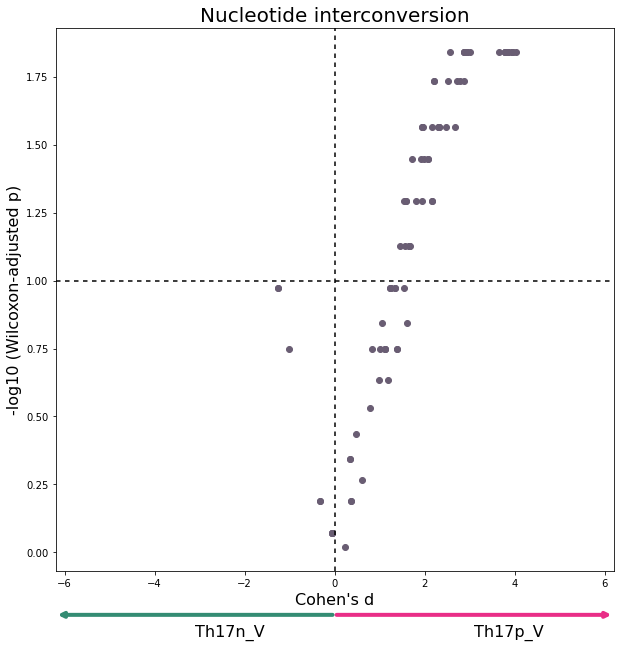

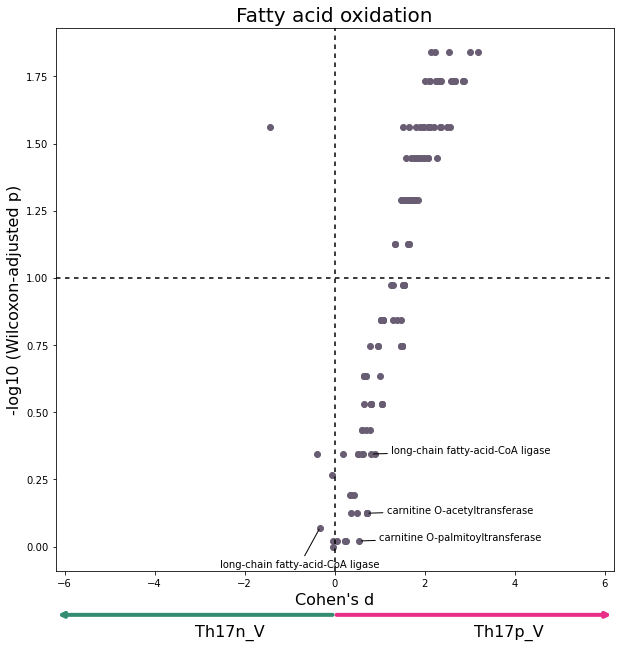

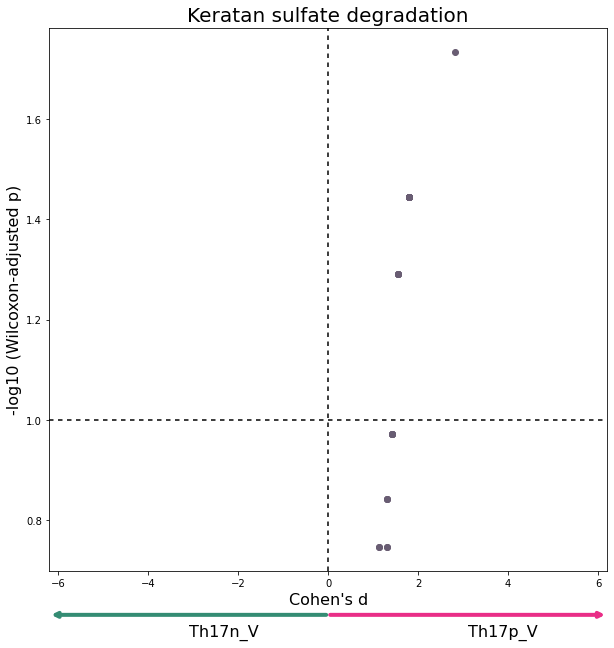

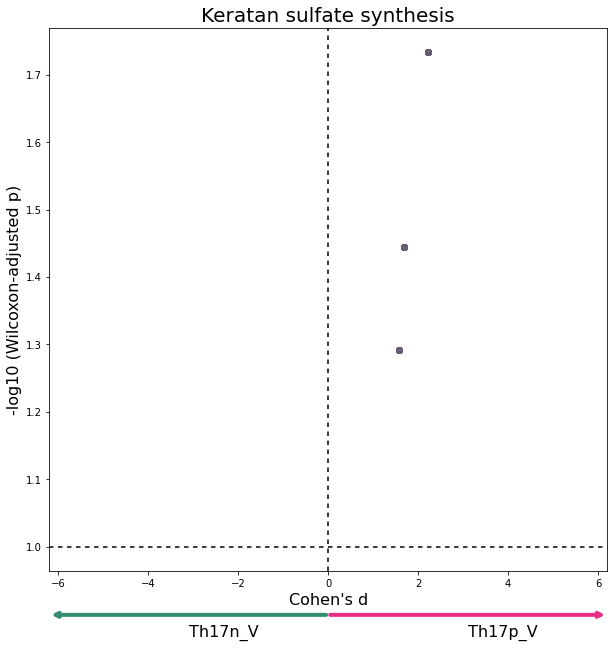

In [29]:
for item in filtered_data['subsystem'].value_counts().keys():
    data = W[W['subsystem'] == item]
    plot_differential_scores(data, title=item, c="#695D73")

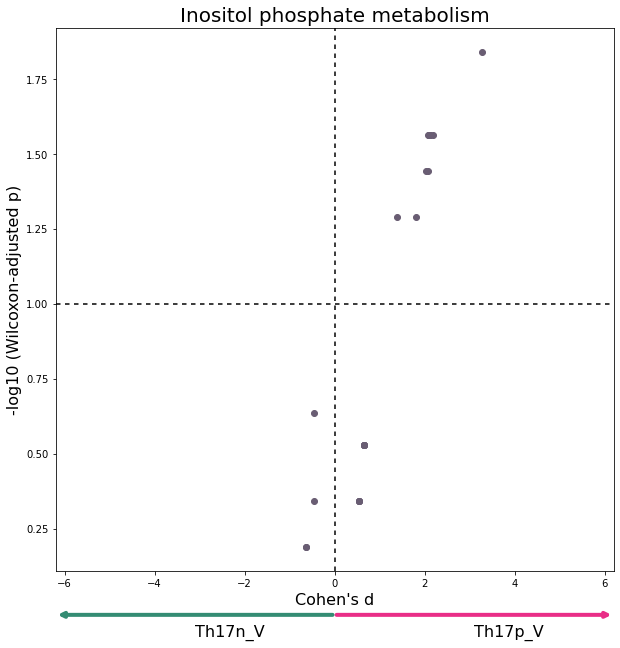

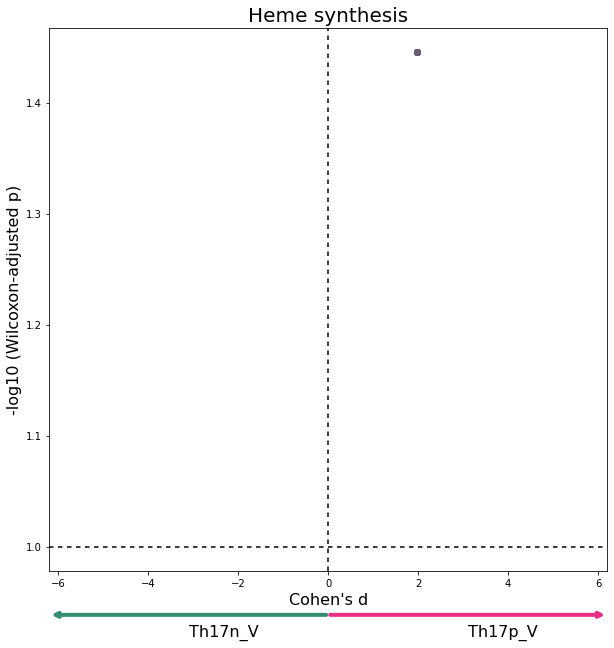

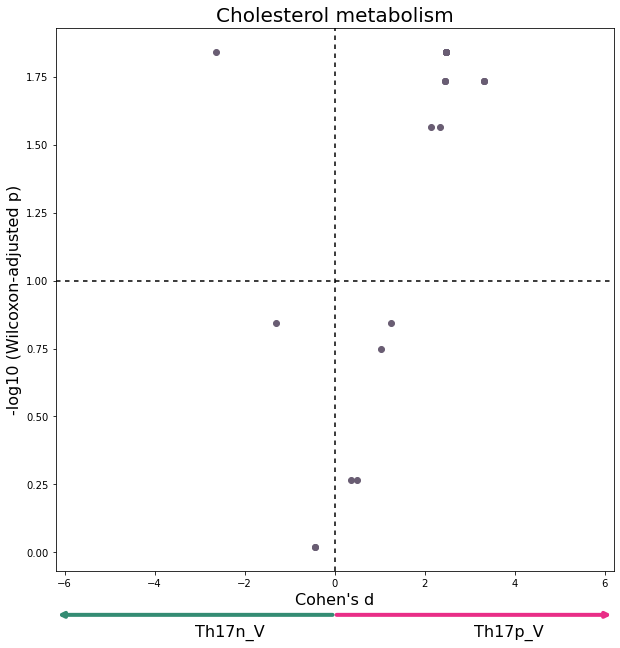

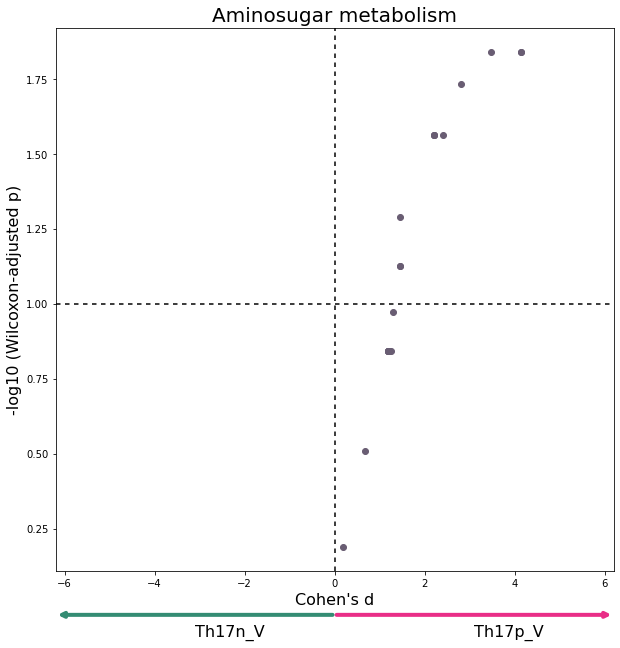

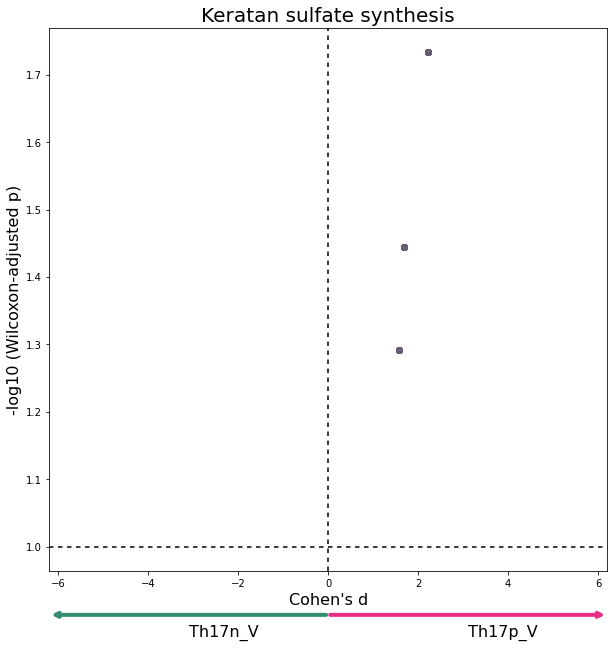

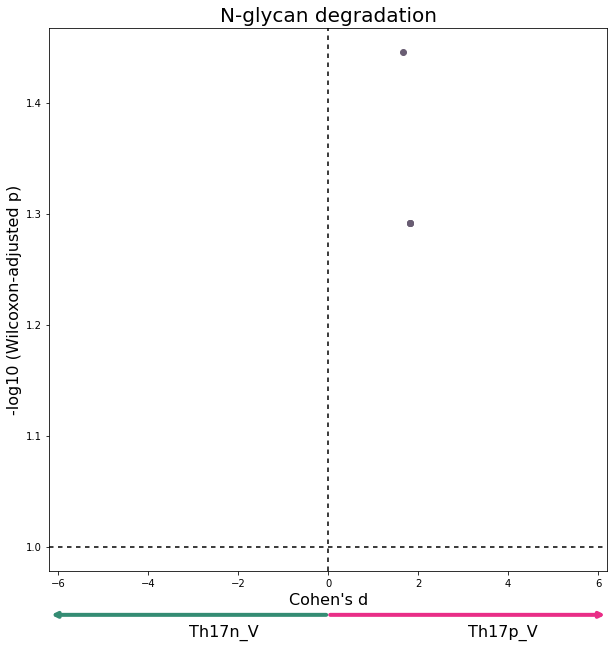

In [30]:
keys = ["Inositol phosphate metabolism", "Heme synthesis", "Cholesterol metabolism", 
        "Aminosugar metabolism", "Keratan sulfate synthesis", "N-glycan degradation"]
for item in keys:
    data = W[W['subsystem'] == item]
    plot_differential_scores(data, title=item, c="#695D73")